Descriptive Statistics:
            Quantity      UnitPrice     TotalPrice
count  353085.000000  353085.000000  353085.000000
mean        6.646972       2.767055      11.360738
std         6.391320       2.761870       8.354469
min         1.000000       0.001000       0.001000
25%         2.000000       1.250000       4.150000
50%         4.000000       1.690000      10.080000
75%        12.000000       3.750000      16.600000
max        27.000000      37.500000      37.950000


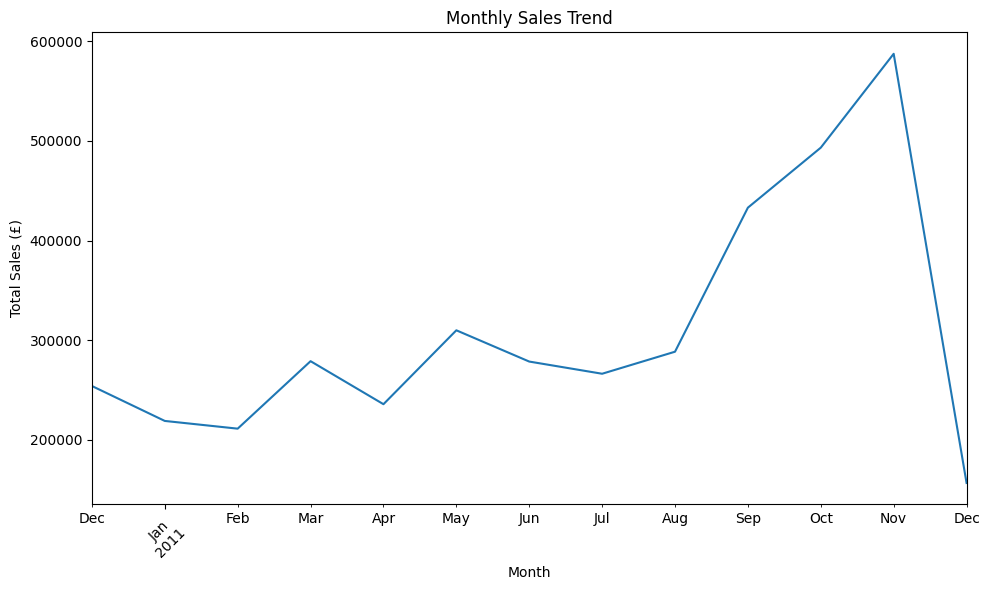

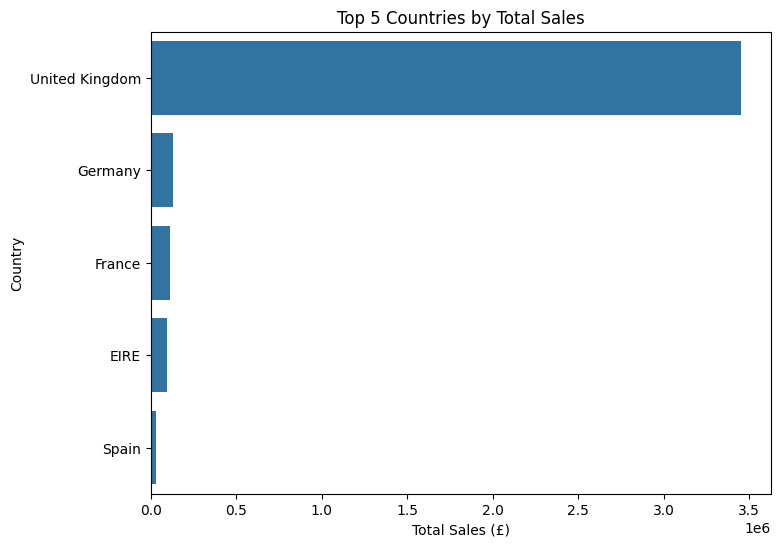

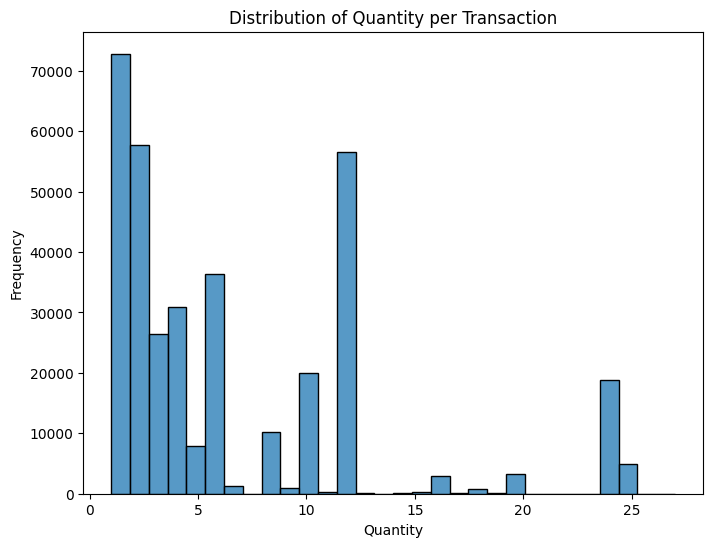

Silhouette Score: 0.572
Interpretation: A score closer to 1 indicates well-separated clusters; above 0.5 is good.


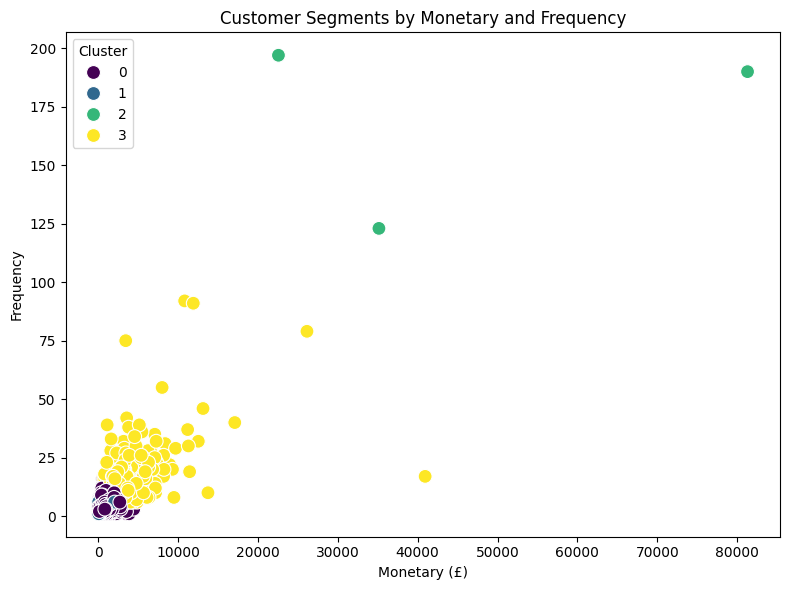

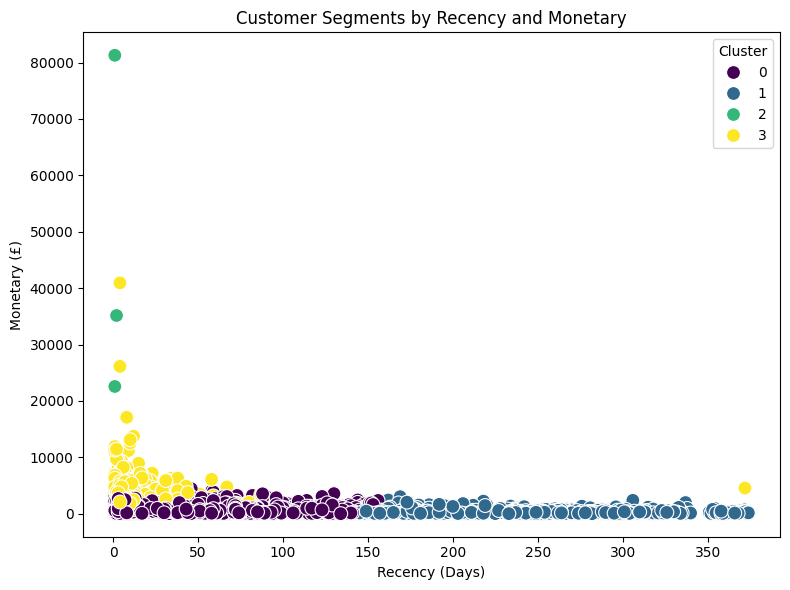

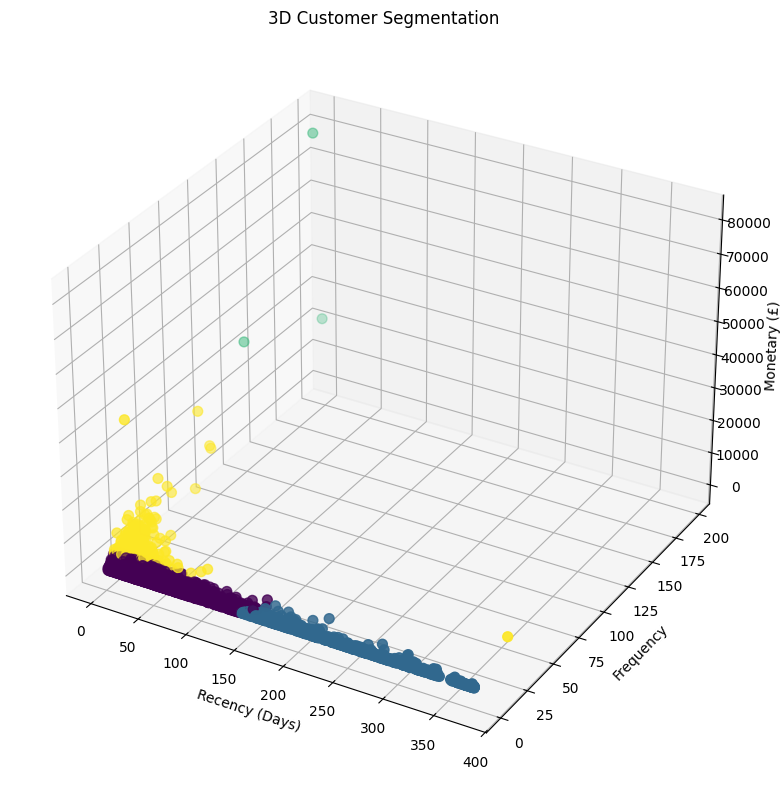

Churn Prediction Accuracy: 1.000
Innovation (Churn Prediction) complete. Top 5 predicted churn risks:
            Recency  Frequency  Monetary  Cluster  Churn  Churn_Prediction
CustomerID                                                                
12348.0         249          3     90.20        1      1                 1
12350.0         310          1    294.40        1      1                 1
12353.0         204          1     49.20        1      1                 1
12354.0         232          1    876.28        1      1                 1
12355.0         214          1    224.80        1      1                 1
All analyses finished.


In [6]:
## Customer Segmentation Analysis for Retail Marketing

## Overview
# This notebook analyzes the Online Retail Dataset to segment customers using K-Means clustering 
# based on RFM (Recency, Frequency, Monetary) scores and introduces a predictive churn model. 
# It includes data cleaning, EDA, clustering, evaluation (2D + 3D), and structured functions.

## Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting
%matplotlib inline

## Data Processing and Analysis Functions

### Function to clean the dataset
def clean_data(df):
    """Clean the Online Retail Dataset by handling missing values, inconsistencies, and outliers."""
    df = df.dropna(subset=['CustomerID'])
    df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
    df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
    for col in ['Quantity', 'TotalPrice']:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        df = df[(df[col] >= Q1 - 1.5 * IQR) & (df[col] <= Q3 + 1.5 * IQR)]
    return df

### Function for exploratory data analysis
def perform_eda(df):
    """Perform EDA with descriptive statistics and visualizations."""
    print("Descriptive Statistics:")
    print(df[['Quantity', 'UnitPrice', 'TotalPrice']].describe())

    df['Month'] = df['InvoiceDate'].dt.to_period('M')
    monthly_sales = df.groupby('Month')['TotalPrice'].sum()
    plt.figure(figsize=(10, 6))
    monthly_sales.plot(kind='line', title='Monthly Sales Trend')
    plt.xlabel('Month')
    plt.ylabel('Total Sales (£)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    country_sales = df.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).head(5)
    plt.figure(figsize=(8, 6))
    sns.barplot(x=country_sales.values, y=country_sales.index)
    plt.title('Top 5 Countries by Total Sales')
    plt.xlabel('Total Sales (£)')
    plt.ylabel('Country')
    plt.show()

    plt.figure(figsize=(8, 6))
    sns.histplot(df['Quantity'], bins=30)
    plt.title('Distribution of Quantity per Transaction')
    plt.xlabel('Quantity')
    plt.ylabel('Frequency')
    plt.show()

### Function to compute RFM scores
def compute_rfm(df):
    """Calculate Recency, Frequency, Monetary scores."""
    snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
    rfm = df.groupby('CustomerID').agg({
        'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
        'InvoiceNo': 'nunique',
        'TotalPrice': 'sum'
    }).rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalPrice': 'Monetary'})
    return rfm

### Function for clustering
def train_kmeans(rfm, n_clusters=4):
    """Apply K-Means clustering to RFM data."""
    scaler = StandardScaler()
    rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)
    return rfm, kmeans

### Function for evaluation including 3D plot
def evaluate_clusters(rfm, kmeans):
    """Evaluate K-Means clustering using silhouette score and visualize clusters in 2D and 3D."""
    rfm_scaled = StandardScaler().fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])
    score = silhouette_score(rfm_scaled, rfm['Cluster'])
    print(f"Silhouette Score: {score:.3f}")
    print("Interpretation: A score closer to 1 indicates well-separated clusters; above 0.5 is good.")

    # 2D Plot: Monetary vs Frequency
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=rfm['Monetary'], y=rfm['Frequency'], hue=rfm['Cluster'], palette='viridis', s=100)
    plt.title('Customer Segments by Monetary and Frequency')
    plt.xlabel('Monetary (£)')
    plt.ylabel('Frequency')
    plt.legend(title='Cluster')
    plt.tight_layout()
    plt.show()

    # 2D Plot: Recency vs Monetary
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=rfm['Recency'], y=rfm['Monetary'], hue=rfm['Cluster'], palette='viridis', s=100)
    plt.title('Customer Segments by Recency and Monetary')
    plt.xlabel('Recency (Days)')
    plt.ylabel('Monetary (£)')
    plt.legend(title='Cluster')
    plt.tight_layout()
    plt.show()

    # 3D Plot: Recency, Frequency, Monetary
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(
        rfm['Recency'], rfm['Frequency'], rfm['Monetary'],
        c=rfm['Cluster'], cmap='viridis', s=50
    )
    ax.set_title('3D Customer Segmentation')
    ax.set_xlabel('Recency (Days)')
    ax.set_ylabel('Frequency')
    ax.set_zlabel('Monetary (£)')
    legend1 = ax.legend(*scatter.legend_elements(), title="Cluster", loc="upper left", bbox_to_anchor=(1.05, 1))
    ax.add_artist(legend1)
    plt.tight_layout()
    plt.show()

### Function for churn prediction
def predict_churn(rfm):
    """Predict customer churn based on RFM scores using a decision tree."""
    rfm['Churn'] = (rfm['Recency'] > 180).astype(int)
    X = rfm[['Recency', 'Frequency', 'Monetary']]
    y = rfm['Churn']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Churn Prediction Accuracy: {accuracy:.3f}")
    
    rfm['Churn_Prediction'] = model.predict(X)
    return rfm

## Main Execution
# Load and clean data
df = pd.read_excel('Online_Retail.xlsx')
df = clean_data(df)
df.to_csv('cleaned_retail_data.csv', index=False)

# Perform EDA
perform_eda(df)

# Compute RFM and cluster
rfm = compute_rfm(df)
rfm, kmeans = train_kmeans(rfm)
rfm.to_csv('rfm_clusters.csv', index=True)

# Evaluate clustering with 2D and 3D visualizations
evaluate_clusters(rfm, kmeans)

# Predict churn as innovation
rfm = predict_churn(rfm)
rfm.to_csv('rfm_churn_prediction.csv', index=True)

print("Innovation (Churn Prediction) complete. Top 5 predicted churn risks:")
print(rfm[rfm['Churn_Prediction'] == 1].head())

print("All analyses finished.")
